In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math 
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
ndata = 1000

X = 1
dx = 0.0005
nx = int(round(X/dx))
#nx= 200
spatial = np.linspace(dx, X, nx)
T = 2
dt = 0.0001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)

In [4]:
# Dataset Generation. Uncomment these lines if you want to generate your own dataset

# def solveThetaFunction(x, gamma):
#     theta = np.zeros(nx)
#     for idx, val in enumerate(x):
#         theta[idx] = 5*math.cos(gamma*math.acos(val)) 
#     return theta

# def solveThetaFunction(x, gamma):
#     theta = np.zeros(nx)
#     for idx, val in enumerate(x):
#         # Original theta definition
#         theta[idx] = (
#             5 * math.cos(gamma * math.acos(val)) +
#             5 * math.cos(20 * gamma * math.acos(val)) 
#         )

        
#     return theta
# def solveKernelFunction(theta):
#     kappa = np.zeros(nx)
#     for i in range(0, nx):
#         kernelIntegral = 0
#         for j in range(0, i):
#             kernelIntegral += (kappa[i-j]*theta[j])*dx
#         kappa[i] = kernelIntegral  - theta[i]
#     return np.flip(kappa)
        
# x = []
# y = [] 
# gammaArr= []
# for i in range(ndata):
#     gamma = np.random.uniform(2, 10)
#     theta = solveThetaFunction(spatial, gamma)
#     kappa = solveKernelFunction(theta)
#     gammaArr.append(gamma)
#     x.append(theta)
#     y.append(kappa)
    
# x= np.array(x, dtype=np.float32)
# y= np.array(y, dtype=np.float32)
# np.savetxt("x.dat", x)
# np.savetxt("y.dat", y)
# np.savetxt("gamma.dat", gammaArr)
# x = x.reshape(x.shape[0], x.shape[1], 1)
# y = y.reshape(y.shape[0], y.shape[1], 1)

In [5]:
# import matplotlib.pyplot as plt

# plt.plot(spatial, theta, label='theta')
# plt.plot(spatial, kappa, label='kappa')
# plt.legend()
# plt.title(f"Theta and Kappa for gamma={gamma}")
# plt.xlabel("x")
# plt.ylabel("value")
# plt.show()

In [6]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# Load sampled input and output
u_x = np.loadtxt("x.dat", dtype=np.float32)  # Shape (ndata, m)
y = np.loadtxt("y.dat", dtype=np.float32)    # Shape (ndata, m_out)

print("Loaded u_x shape:", u_x.shape)
print("Loaded y shape:", y.shape)

# Get dimensions dynamically
ndata, m_in = u_x.shape
_, m_out = y.shape
# Desired number of spatial points
m = 200

# Choose m evenly spaced indices across the original m_in 
original_m = u_x.shape[1]
downsampled_idx = np.linspace(0, original_m - 1, m, dtype=int)

# Downsample the input and output
u_x = u_x[:, downsampled_idx]  # shape (ndata, 300)
y = y[:, downsampled_idx]      # shape (ndata, 300)

# Reshape into (ndata, m, 1)
u_x = u_x.reshape(ndata, m, 1)
y = y.reshape(ndata, m, 1)

# Create downsampled grid for each function
grid_in = np.linspace(0, 1, m, dtype=np.float32)
grid_expanded = np.tile(grid_in, (ndata, 1)).reshape(ndata, m, 1)

# Concatenate for FNO input: (u(x), x)
x_fno = np.concatenate([u_x, grid_expanded], axis=-1)  # (ndata, m_in, 2)

# Split and permute for FNO (batch, channels=2, spatial)
x_train, x_test, y_train, y_test = train_test_split(x_fno, y, test_size=0.1, random_state=1)

x_train = torch.tensor(x_train, dtype=torch.float32).cuda().permute(0, 2, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).cuda().permute(0, 2, 1)
x_test = torch.tensor(x_test, dtype=torch.float32).cuda().permute(0, 2, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).cuda().permute(0, 2, 1)

# Final shapes
print("FNO Input Shape:", x_train.shape)   # (batch_size, 2, m_in)
print("FNO Output Shape:", y_train.shape)  # (batch_size, 1, m_out)




Loaded u_x shape: (1000, 2000)
Loaded y shape: (1000, 2000)
FNO Input Shape: torch.Size([900, 2, 200])
FNO Output Shape: torch.Size([900, 1, 200])


In [7]:
from neuralop.models import FNO1d
import torch.nn as nn

class FNOModel(nn.Module):
    def __init__(self, modes=24, width=128, in_channels=2, out_channels=1):
        super(FNOModel, self).__init__()
        self.fno = FNO1d(
            n_modes_height=modes,  
            hidden_channels=width,  
            in_channels=in_channels, 
            out_channels=out_channels,  
            lifting_channels=width,  
            projection_channels=width,
            dropout=0.05, 
            n_layers=5, 
            skip="soft-gating"  
        )

    def forward(self, x):
        return self.fno(x)  


In [8]:
import torch
import time
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

# Initialize model
modes = 32
width = 64
model = FNOModel(modes, width).cuda()

# Optimizer and scheduler
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=2e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-5)
loss_fn = LpLoss() 

# Dataloader
batch_size = 20
from torch.utils.data import DataLoader, TensorDataset

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))


In [9]:
epochs = 1000
train_lossArr = []
test_lossArr = []

for ep in range(epochs):
    model.train()
    t1 = time.time()
    train_loss = 0

    for x, y in trainData:
        optimizer.zero_grad()

        out = model(x)  # Forward pass
        loss = loss_fn(out, y)  # Compute loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    scheduler.step()
    
    # Evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            out = model(x)
            test_loss += loss_fn(out, y).item()

    train_loss /= len(trainData) 
    test_loss /= len(testData)

    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)

    t2 = time.time()
    if ep % 50 == 0:
        print(f"Epoch {ep}: Time {t2 - t1:.2f}s, Train Loss {train_loss:.6f}, Test Loss {test_loss:.6f}")


Epoch 0: Time 1.18s, Train Loss 0.992625, Test Loss 0.976872
Epoch 50: Time 0.60s, Train Loss 0.505440, Test Loss 0.556965
Epoch 100: Time 0.61s, Train Loss 0.336630, Test Loss 0.411251
Epoch 150: Time 0.77s, Train Loss 0.228136, Test Loss 0.273399
Epoch 200: Time 0.57s, Train Loss 0.184980, Test Loss 0.225352
Epoch 250: Time 0.61s, Train Loss 0.154613, Test Loss 0.208634
Epoch 300: Time 0.59s, Train Loss 0.151576, Test Loss 0.192572
Epoch 350: Time 0.57s, Train Loss 0.129877, Test Loss 0.181246
Epoch 400: Time 0.58s, Train Loss 0.118108, Test Loss 0.154034
Epoch 450: Time 0.56s, Train Loss 0.103104, Test Loss 0.154369
Epoch 500: Time 0.61s, Train Loss 0.090986, Test Loss 0.136342
Epoch 550: Time 0.60s, Train Loss 0.080852, Test Loss 0.123857
Epoch 600: Time 0.63s, Train Loss 0.070721, Test Loss 0.116420
Epoch 650: Time 0.60s, Train Loss 0.064828, Test Loss 0.109664
Epoch 700: Time 0.58s, Train Loss 0.053272, Test Loss 0.102098
Epoch 750: Time 0.60s, Train Loss 0.048199, Test Loss 0.09

In [10]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

Final Testing Loss: 0.07962102368474007
Final Training Loss: 0.027438441705372598


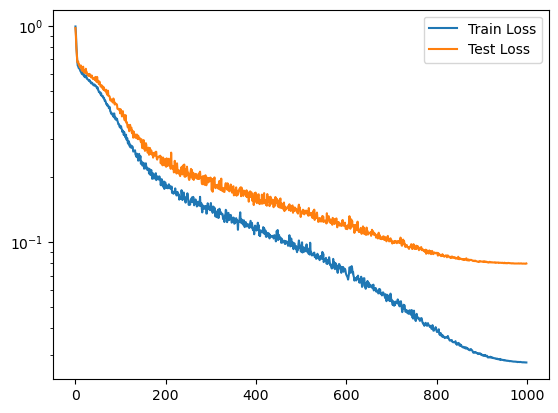

In [11]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

with torch.no_grad():
    trainLoss = 0
    for x, y in trainData:
        out = model(x)  
        trainLoss += loss_fn(out.view(batch_size, -1), y.view(batch_size, -1)).item()  

    testLoss = 0
    for x, y in testData:
        out = model(x)  
        testLoss += loss_fn(out.view(batch_size, -1), y.view(batch_size, -1)).item() 
    
    
#print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss/len(testData))
print("Final Training Loss:", trainLoss/len(trainData))

In [ ]:
import numpy as np

# ----------------------------------------------------------------------
# 1.  Kernel from θ   (back‑stepping integral equation, forward sweep)
# ----------------------------------------------------------------------
def solve_kernel(theta, dx):
    """
    Parameters
    ----------
    theta : (nx,)  np.ndarray
        β(x) sampled on the SAME grid you will use for the PDE.
    dx    : float
        Grid spacing (x[1]-x[0]).
    Returns
    -------
    kappa : (nx,) np.ndarray      (already flipped for convolution use)
    """
    nx    = len(theta)
    kappa = np.zeros(nx, dtype=theta.dtype)

    #   κ(i) = -θ(i) + ∑_{j<i} κ(i-j) θ(j) Δx
    for i in range(nx):
        # dot(kappa[0:i][::-1], theta[0:i])  is  ∑_{j<i} κ(i-j-1) θ(j)
        kernel_int = np.dot(kappa[:i][::-1], theta[:i]) * dx
        kappa[i]   = kernel_int - theta[i]

    return kappa[::-1]                    # flip once at the end

def solveControl(u, kernel, dx):
    # vectorised dot product, no globals
    return np.dot(kernel, u) * dx

def solvePDE(theta, kappa, init_condition, x, t):
    nx = len(x)               # <- local size
    nt = len(t)
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u = np.zeros((nt, nx), dtype=np.float32)
    U = np.zeros(nt,        dtype=np.float32)
    u[0] = init_condition.copy()

    print("Solving PDE... Timesteps Needed:", nt)
    for n in range(1, nt):
        if n % (nt // 10) == 0:
            print(f"Completed: {n} / {nt}")

        # boundary control at x = 1
        u[n-1, -1] = solveControl(u[n-1], kappa, dx)
        U[n-1]     = u[n-1, -1]

        # up‑wind update (same stencil you used)
        du_dx        = np.empty_like(u[n-1])
        du_dx[:-1]   = (u[n-1, 1:] - u[n-1, :-1]) / dx
        du_dx[-1]    = 0.0
        u[n]         = u[n-1] + dt * (du_dx + theta * u[n-1, 0])
    return u, U


# ----------------------------------------------------------------------
# 4.  Open‑loop reference (U(t) = 0 at the boundary)
# ----------------------------------------------------------------------
def solveOpenLoop(theta, kappa, init_condition, x, t):
    
    u = np.zeros((len(t), len(x)))

    # Set intial condition
    for i in range(len(x)):
        u[0][i] = init_condition[i]

    for i in range(1, len(t)):
        u[i][-1] = 0
        for j in range(0, nx-1):
            u[i][j] = u[i-1][j] + dt*((u[i-1][j+1] - u[i-1][j])/dx + theta[j]*u[i-1][0])
    
    return u


# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt)
    for i in range(nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i] = error
    return pdeError


In [27]:
from scipy.interpolate import interp1d        # one‑time import at top of file

def upsample_to_fine(coarse_vec, x_fine):
    """
    coarse_vec : (m,)      vector on the same grid as your FNO output (m = 200)
    x_fine     : (nx_f,)   fine grid you want to run the PDE on (nx_f = 2000)
    returns    : (nx_f,)   vector resampled onto x_fine  (cubic ⇢ smooth)
    """
    m = len(coarse_vec)
    x_coarse = np.linspace(0.0, 1.0, m, dtype=np.float32)
    f = interp1d(x_coarse, coarse_vec, kind="cubic", fill_value="extrapolate")
    return f(x_fine).astype(np.float32)

# Get 20 instances of test data. 
for x, y in testData:
    xinst, yinst = x, y
    #xinst = xinst.permute(0, 2, 1)  
    #yinst = yinst.permute(0, 2, 1) 
    out = model(xinst)
print("x[-1] shape:", x[-1].shape)  # Expected: (1000,)
print("y[-1] shape:", y[-1].shape)  # Expected: (1000,)
print("spatial shape:", spatial.shape)  # Expected: (1000,)

print(out.shape)
# Get instances
ndata = 2
yhat = []
x = []
y = []
#nx = 200
# Handpick
# Build beta = 3 example
def solveThetaFunction(x, gamma):
    theta = np.zeros_like(x)
    for idx, val in enumerate(x):
        theta[idx] = (
            5 * math.cos(gamma * math.acos(val)) +
            5 * math.cos(20 * gamma * math.acos(val)) 
        )
    return theta

def solveKernelFunction(theta, dx):
    n = len(theta)
    kappa = np.zeros(n)
    for i in range(n):
        kernelIntegral = 0
        for j in range(i):
            kernelIntegral += (kappa[i - j] * theta[j]) * dx
        kappa[i] = kernelIntegral - theta[i]
    return np.flip(kappa)

# Decide to load model pretrained or use model. To use pretrained uncomment this line. To use trained, 
#comment this line
#model.load_state_dict(torch.load('betaToKTorchModel'))
    

gamma = 3
grid = np.linspace(0, 1, nx)

theta = np.array(solveThetaFunction(grid, gamma), dtype=np.float32)
kappa = np.array(solveKernelFunction(theta, dx), dtype=np.float32)

# Convert to torch tensors
theta = torch.tensor(theta.reshape(1, 1, nx), dtype=torch.float32).cuda()  # Shape (1, 1, nx)
kappa = torch.tensor(kappa.reshape(1, 1, nx), dtype=torch.float32).cuda()  # Shape (1, 1, nx)

# Convert grid to tensor                                                                                                                                                                                                                                                                                                                
grid_tensor = torch.tensor(grid.reshape(1, 1, nx), dtype=torch.float32).cuda()  # Shape (1, 1, nx)

# Concatenate theta and grid for FNO input
theta_input = torch.cat([theta, grid_tensor], dim=1)  # Shape (1, 2, nx)

# Run inference
res = model(theta_input)

yhat.append(res.cpu().detach().numpy().flatten())
x.append(theta.cpu().detach().numpy().flatten())
y.append(kappa.cpu().detach().numpy().flatten())

inst = 13
yhat.append(out[inst].cpu().detach().numpy().flatten())
x.append(xinst[inst, 0].cpu().detach().numpy().flatten())  # Keep only first channel

y.append(yinst[inst].cpu().detach().numpy().flatten())  
#print("Gamma for Inst 2:", getGamma(x[-1]))
print("x[-1] shape:", x[-1].shape)  # Expected: (1000,)
print("y[-1] shape:", y[-1].shape)  # Expected: (1000,)
print("yhat[-1] shape:", yhat[-1].shape)  # Expected: (1000,)
print("spatial shape:", spatial.shape)  # Expected: (1000,)

topenloop = np.linspace(0, 5, int(nt*2.5))

# Showcase PDE Difference
init_cond = np.zeros(nx)
init_cond.fill(10)
#topenloop = np.linspace(0, 5, 5000)
uarr = []
uhatarr = []
uopenarr = []


for i in range(ndata):
    if i == 1:
        init_cond = np.zeros((nx))
        init_cond.fill(5)
    # 1) up‑sample EVERYTHING to the fine spatial grid (len(spatial) == 2000)
    theta_fine   = upsample_to_fine(x[i],       spatial)   # β = θ
    kappa_fine   = upsample_to_fine(y[i],       spatial)   # κ  (true)
    kappa_hat_f  = upsample_to_fine(yhat[i],    spatial)   # κ̂ (pred)

    init_fine    = upsample_to_fine(init_cond,  spatial)   # IC on fine grid

    # 2) run closed‑loop / open‑loop on the fine grid
    u,   U    = solvePDE(theta_fine, kappa_fine,   init_fine, spatial, temporal)
    uhat, Uh = solvePDE(theta_fine, kappa_hat_f,   init_fine, spatial, temporal)
    uarr.append(u)
    uhatarr.append(uhat)

    # toss κ because open‑loop has no boundary feedback
    u_open = solveOpenLoop(theta_fine, kappa_fine, init_fine, spatial, topenloop)

    uopenarr.append(u_open)


x[-1] shape: torch.Size([2, 200])
y[-1] shape: torch.Size([1, 200])
spatial shape: (2000,)
torch.Size([20, 1, 200])
x[-1] shape: (200,)
y[-1] shape: (200,)
yhat[-1] shape: (200,)
spatial shape: (2000,)
Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed: 12000 / 20000
Completed: 14000 / 20000
Completed: 16000 / 20000
Completed: 18000 / 20000
Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed: 12000 / 20000
Completed: 14000 / 20000
Completed: 16000 / 20000
Completed: 18000 / 20000
Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed: 12000 / 20000
Completed: 14000 / 20000
Completed: 16000 / 20000
Completed: 18000 / 20000
Solving PDE... Tim

In [28]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

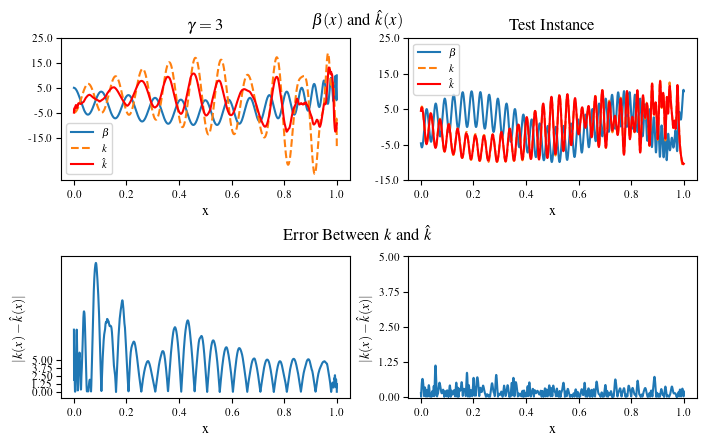

In [29]:
from scipy.interpolate import interp1d

fig = plt.figure(figsize=set_size(516, 0.99, (2, 2)))
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

# -- Interpolate coarse data to match spatial resolution (nx = 500) --
m = x[0].shape[0]
sample_indices = np.round(np.linspace(0, len(spatial) - 1, m)).astype(int)
spatial_coarse = spatial[sample_indices]

# Helper function to interpolate 1D arrays
def upsample_to_spatial(arr_1d):
    """
    Convert any 1‑D array sampled on [0,1] to the fine `spatial` grid.
    If the array is already the correct length, return it unchanged.
    """
    if len(arr_1d) == len(spatial):          # already 2 000 points
        return arr_1d

    x_src = np.linspace(0.0, 1.0, len(arr_1d), dtype=np.float32)
    f     = interp1d(x_src, arr_1d, kind='cubic', fill_value="extrapolate")
    return f(spatial)


x_upsampled = [upsample_to_spatial(xi) for xi in x]
y_upsampled = [upsample_to_spatial(yi) for yi in y]
yhat_upsampled = [upsample_to_spatial(yi) for yi in yhat]

# ---------- Subfigure 1: beta and kernels ----------
subfig = subfigs[0]
subfig.suptitle(r"$\beta(x)$ and $\hat{k}(x)$")
subfig.subplots_adjust(left=0.08, bottom=0.2, right=0.98, top=0.85, wspace=0.2, hspace=0.2)
ax = subfig.subplots(nrows=1, ncols=2)

yticks = np.linspace(-15, 25, 5)

# Plot for gamma = 3
ax[0].plot(spatial, x_upsampled[0], label=r"$\beta$")
ax[0].plot(spatial, np.flip(y_upsampled[0]), label=r"$k$", linestyle='--')
ax[0].plot(spatial, np.flip(yhat_upsampled[0]), label=r"$\hat{k}$", color="red")
ax[0].legend()
ax[0].set_xlabel("x")
ax[0].ticklabel_format(style='sci', scilimits=(-3, 4), axis='both')
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].set_yticks(yticks)
ax[0].set_title(r"$\gamma=3$")

# Plot for test instance
ax[1].plot(spatial, x_upsampled[1], label=r"$\beta$")
ax[1].plot(spatial, np.flip(y_upsampled[1]), label=r"$k$", linestyle='--')
ax[1].plot(spatial, np.flip(yhat_upsampled[1]), label=r"$\hat{k}$", color="red")
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].ticklabel_format(style='sci', scilimits=(-3, 4), axis='both')
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].set_yticks(yticks)
ax[1].set_title("Test Instance")

# ---------- Subfigure 2: Error plots ----------
yticks = np.linspace(0, 5, 5)

subfig = subfigs[1]
subfig.subplots_adjust(left=0.08, bottom=0.2, right=0.98, top=.85, wspace=0.2, hspace=0.2)
subfig.suptitle(r"Error Between $k$ and $\hat{k}$")
ax = subfig.subplots(nrows=1, ncols=2)

ax[0].plot(spatial, abs(y_upsampled[0] - yhat_upsampled[0]))
ax[0].ticklabel_format(style='sci', scilimits=(-3, 4), axis='y')
ax[0].set_xlabel("x")
ax[0].set_ylabel(r"$|k(x)-\hat{k}(x)|$")
ax[0].set_yticks(yticks)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[1].plot(spatial, abs(y_upsampled[1] - yhat_upsampled[1]))
ax[1].ticklabel_format(style='sci', scilimits=(-3, 4), axis='y')
ax[1].set_xlabel("x")
ax[1].set_ylabel(r"$|k(x)-\hat{k}(x)|$")
ax[1].set_yticks(yticks)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


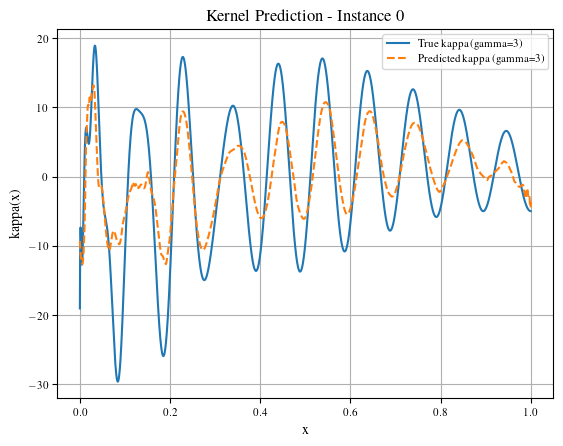

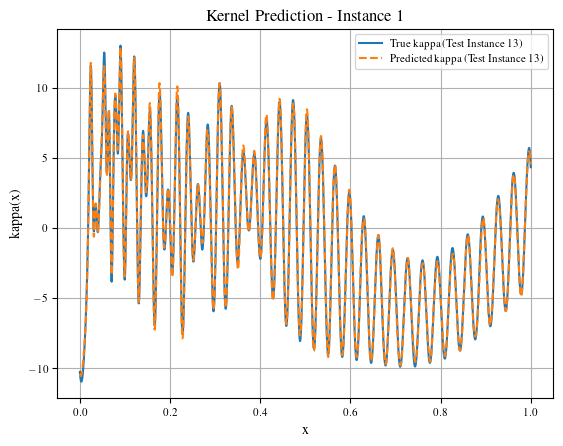

In [30]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Assume spatial = (500,), y[0], yhat[0] = (200,)
m = y[0].shape[0]
sample_indices = np.round(np.linspace(0, len(spatial) - 1, m)).astype(int)
spatial_coarse = spatial[sample_indices]

def upsample(arr_1d):
    """
    Convert any 1‑D array sampled on [0,1] to the fine `spatial` grid.
    If the array is already the correct length, return it unchanged.
    """
    if len(arr_1d) == len(spatial):          # already 2 000 points
        return arr_1d

    x_src = np.linspace(0.0, 1.0, len(arr_1d), dtype=np.float32)
    f     = interp1d(x_src, arr_1d, kind='cubic', fill_value="extrapolate")
    return f(spatial)


# Upsample all data
y0_interp = upsample(y[0])
yhat0_interp = upsample(yhat[0])
y1_interp = upsample(y[1])
yhat1_interp = upsample(yhat[1])

# Plot instance 0
plt.plot(spatial, y0_interp, label='True kappa (gamma=3)')
plt.plot(spatial, yhat0_interp, label='Predicted kappa (gamma=3)', linestyle='--')
plt.legend()
plt.title("Kernel Prediction - Instance 0")
plt.xlabel("x")
plt.ylabel("kappa(x)")
plt.grid(True)
plt.show()

# Plot instance 1 (test instance 13)
plt.plot(spatial, y1_interp, label='True kappa (Test Instance 13)')
plt.plot(spatial, yhat1_interp, label='Predicted kappa (Test Instance 13)', linestyle='--')
plt.legend()
plt.title("Kernel Prediction - Instance 1")
plt.xlabel("x")
plt.ylabel("kappa(x)")
plt.grid(True)
plt.show()



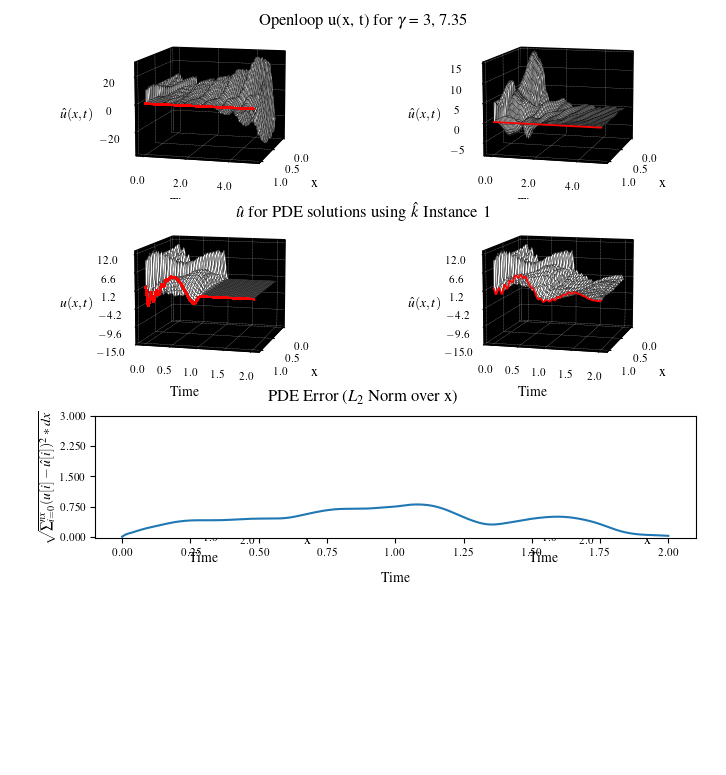

In [31]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (3, 2), height_add=1))
plt.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=4, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"Openloop u(x, t) for $\gamma$ = 3, 7.35")
meshx, mesht = np.meshgrid(spatial, topenloop)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uopenarr[0], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(2.5*nt))
vals = (uopenarr[0].transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], topenloop[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$\hat{u}(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uopenarr[1], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(int(2.5*nt))
vals = (uopenarr[1].transpose())[-1] 
ax[1].plot(test[1:], topenloop[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[1]
subfig.suptitle(r"$\hat{u}$ for PDE solutions using $\hat{k}$ Instance 1")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uarr[0], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(nt)
vals = (uarr[0].transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1].plot_surface(meshx, mesht, uhatarr[0], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uhatarr[0].transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_zticks(zticks)
ax[0].set_zticks(zticks)

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[2]
subfig.suptitle(r"$\hat{u}$ for PDE solutions using $\hat{k}$ Instance 2")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uarr[1], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(nt)
vals = (uarr[1].transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uhatarr[1], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uhatarr[1].transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_zticks(zticks)
ax[0].set_zticks(zticks)

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[2]  # Now this is the third subfigure, after deleting one
zticks = np.linspace(0, 3, 5)
subfig.suptitle(r"PDE Error ($L_2$ Norm over x)")
ax = subfig.subplots()  # Single axis instead of (1,2)
subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)

# Only plot for instance 1 (originally ax[0])
ax.plot(temporal, getPDEl2(uarr[1], uhatarr[1]))
ax.ticklabel_format(style='sci', scilimits=(-3, 4), axis='both')
ax.set_xlabel("Time", labelpad=10)
ax.set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_yticks(zticks)



In [ ]:
torch.save(model.state_dict(), "betaToKTorchModel")